In [ ]:
# this loads  the behavioral data for the discovery sample and looks at their performance across sessions

In [1]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn
import json
import datetime
import pickle
import seaborn as sns
import gc
import psutil
import math
import scipy.stats as stats
from matplotlib.patches import Patch
from nilearn import plotting
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.image import concat_imgs, mean_img, index_img
from nilearn.reporting import make_glm_report
from nilearn import masking, image
from nilearn import datasets
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
# subjects in the discovery sample
SUBJECTS = ['s03', 's10', 's19', 's29', 's43']
BASE_DIR = '/oak/stanford/groups/russpold/data/network_grant/behavioral_data/qc/discovery/'
filename_ending = '_desc-qc.csv'

In [3]:
subj_files = {}

In [4]:
for subj in SUBJECTS:
    subj_files[subj] = {'file_loc':[],'loaded':[]}
    subj_files[subj]['file_loc'] = f'{BASE_DIR}{subj}/{subj}{filename_ending}'

    try:
        df = pd.read_csv(subj_files[subj]['file_loc'])
        subj_files[subj]['loaded'] = df
    except FileNotFoundError:
        print(f"File not found: {subj_files[subj]['file_loc']}")
    except Exception as e:
        print(f"An error occurred while loading {subj_files[subj]['file_loc']}: {e}")

In [5]:
def split_info(df):
    df[['subject', 'session', 'task']] = df['info'].str.split('_', expand=True)
    return df

for subj in SUBJECTS:
    print(f"for subj {subj}")
    # print(subj_files[subj]['loaded'])

    curr_df = subj_files[subj]['loaded']
    curr_df = split_info(curr_df).drop(columns = "info")
    curr_df['task_count'] = curr_df.groupby(['subject', 'task']).cumcount() + 1
    
    subj_files[subj]['loaded'] = curr_df

    print(subj_files[subj]['loaded'].head())   

for subj s03
     go_acc  nogo_acc       go_rt  nogo_fail_rt   SDD_acc  DNN_acc  DDD_acc  \
0  0.977778       1.0  467.840909           NaN       NaN      NaN      NaN   
1       NaN       NaN         NaN           NaN  0.913043     0.96     0.96   
2       NaN       NaN         NaN           NaN       NaN      NaN      NaN   
3       NaN       NaN         NaN           NaN       NaN      NaN      NaN   
4       NaN       NaN         NaN           NaN       NaN      NaN      NaN   

   DDS_acc  SSS_acc  DSD_acc  ...  incongruent_stop_acc  incongruent_go_acc  \
0      NaN      NaN      NaN  ...                   NaN                 NaN   
1      1.0      0.9      1.0  ...                   NaN                 NaN   
2      NaN      NaN      NaN  ...                   NaN                 NaN   
3      NaN      NaN      NaN  ...                   NaN                 NaN   
4      NaN      NaN      NaN  ...                   NaN                 NaN   

   congruent_go_succ_rt  congruent_st

In [6]:
dataframes = []

for subj in SUBJECTS:
    if subj_files[subj]['loaded'] is not None:
        dataframes.append(subj_files[subj]['loaded'])

# Concatenate all dfs
combined_df = pd.concat(dataframes, ignore_index=True)

In [7]:
task_list = [task for task in combined_df["task"].unique() if task is not None]
print(task_list)

['goNogo', 'shapeMatching', 'spatialTS', 'cuedTS', 'directedForgetting', 'flanker', 'nBack', 'stopSignal', 'directedForgettingWFlanker', 'stopSignalWDirectedForgetting', 'stopSignalWFlanker']


In [9]:
dfs_task_list = {}
task_acc_list = {}
task_rt_list = {}
for task in task_list:
    curr_df = combined_df[combined_df["task"] == task].dropna(axis=1, how='any')
    # Store the filtered DataFrame in the dictionary
    dfs_task_list[task] = curr_df

    # print(dfs_task_list[task])

    # save the name of the acc cols:
    acc_columns = [col for col in curr_df.columns if col.endswith('_acc')]
    task_acc_list[task] = acc_columns

    rt_columns = [col for col in curr_df.columns if col.endswith('_rt')]
    task_rt_list[task] = rt_columns
    
    print(task_acc_list[task])

print(dfs_task_list)
print(task_rt_list)

['go_acc', 'nogo_acc']
['SDD_acc', 'DNN_acc', 'DDD_acc', 'DDS_acc', 'SSS_acc', 'DSD_acc', 'SNN_acc']
['cstay_acc', 'cswitch_tstay_acc', 'cswitch_tswitch_acc']
['cstay_acc', 'cswitch_tstay_acc', 'cswitch_tswitch_acc']
['con_acc', 'pos_acc', 'neg_acc']
['congruent_acc', 'incongruent_acc']
['mismatch_1back_acc', 'match_1back_acc', 'mismatch_2back_acc', 'match_2back_acc']
['stop_succ_acc', 'go_succ_acc']
['pos_incongruent_acc', 'neg_incongruent_acc', 'con_incongruent_acc', 'pos_congruent_acc', 'neg_congruent_acc', 'con_congruent_acc']
['pos_stop_acc', 'pos_go_acc', 'neg_stop_acc', 'neg_go_acc', 'con_stop_acc', 'con_go_acc']
['congruent_stop_acc', 'congruent_go_acc', 'incongruent_stop_acc', 'incongruent_go_acc']
{'goNogo':        go_acc  nogo_acc       go_rt subject session    task  task_count
0    0.977778  1.000000  467.840909     s03  ses-01  goNogo         1.0
8    1.000000  0.982456  370.697436     s03  ses-03  goNogo         2.0
16   0.961722  1.000000  418.666667     s03  ses-05  goN

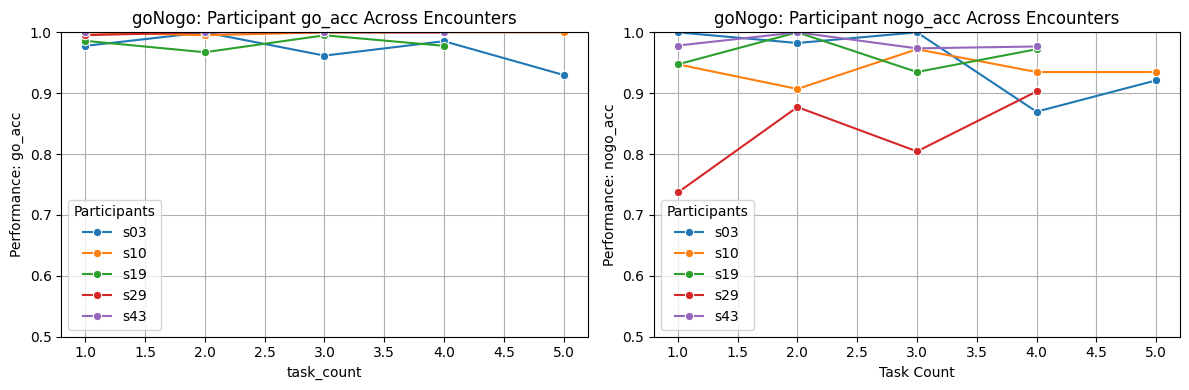

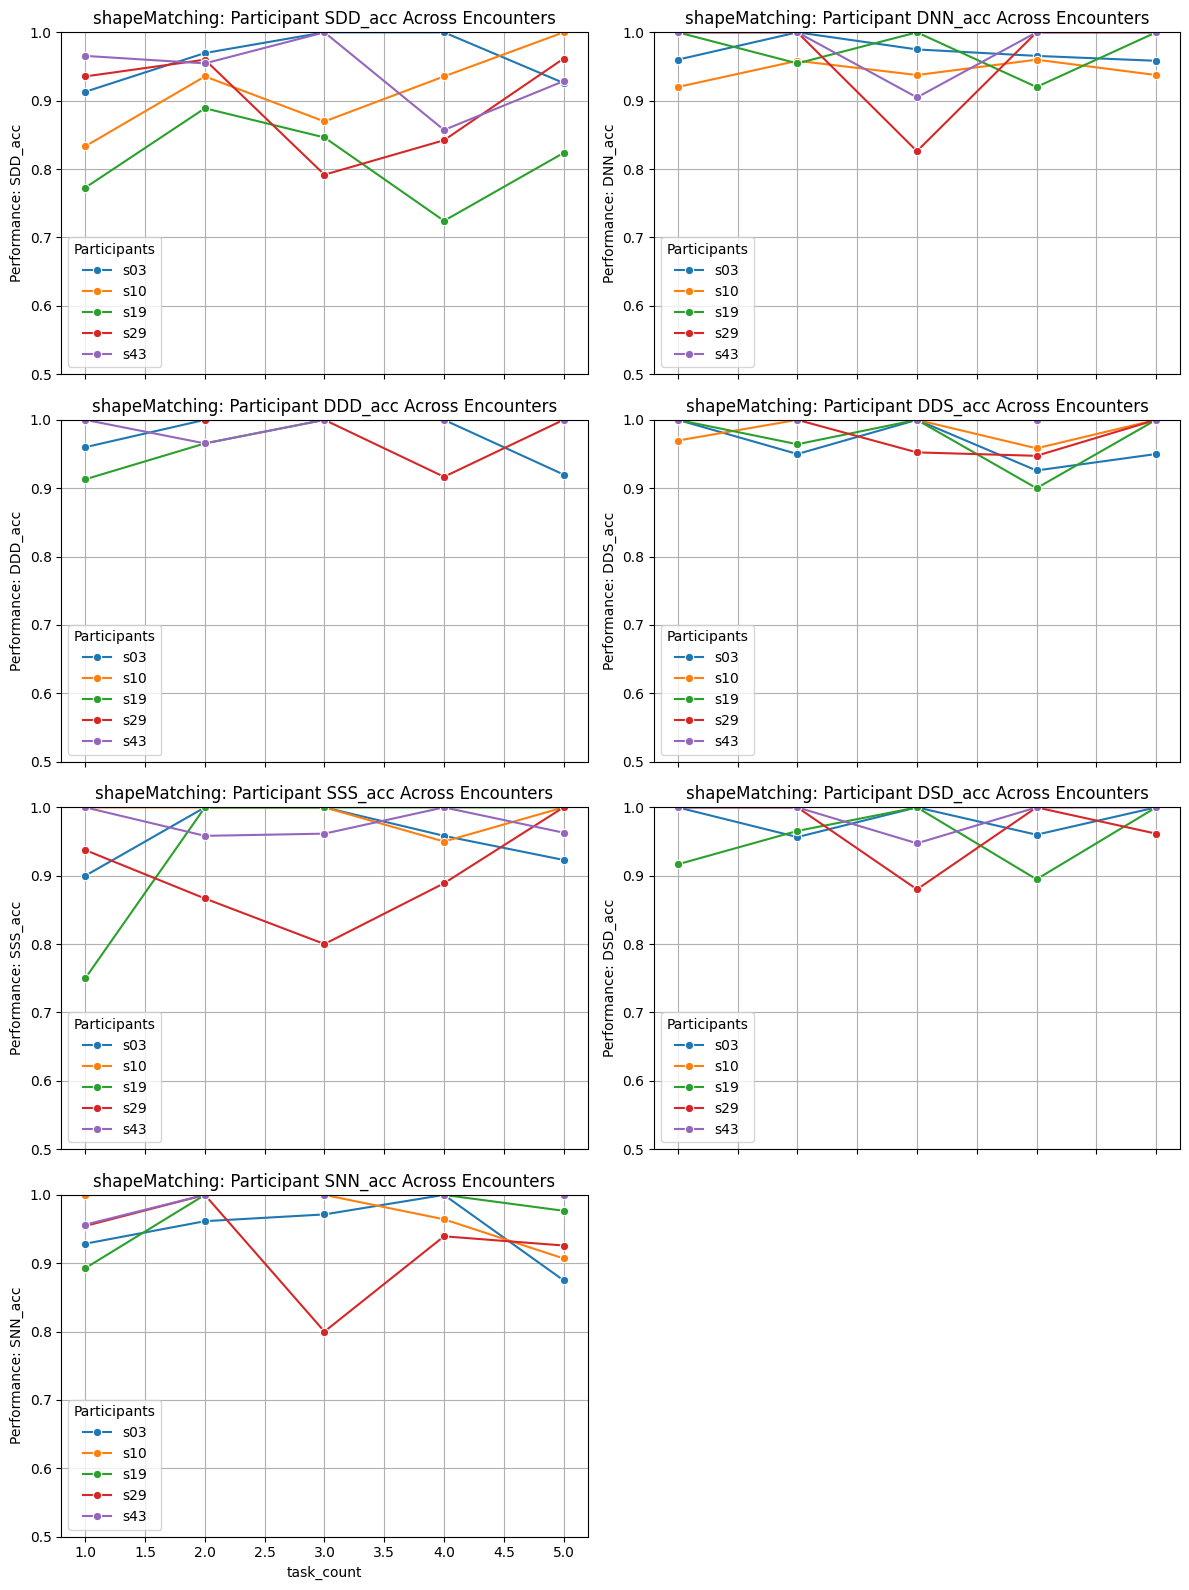

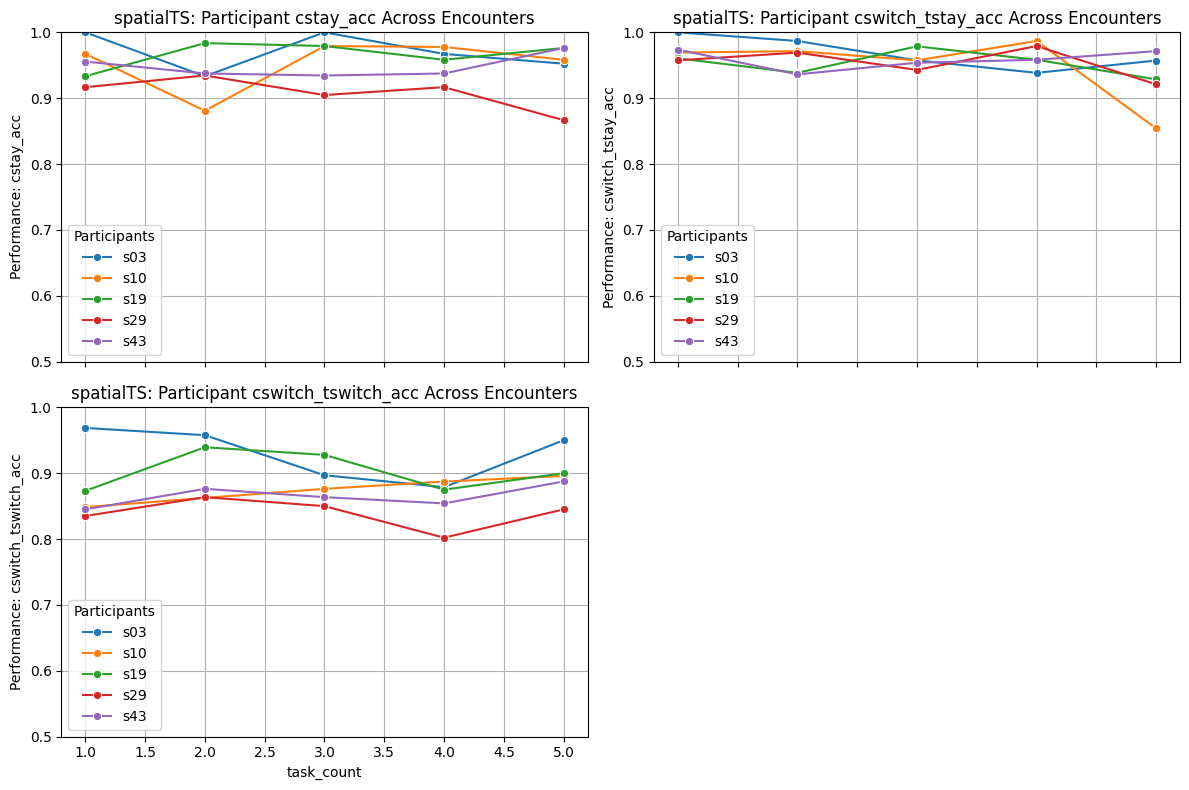

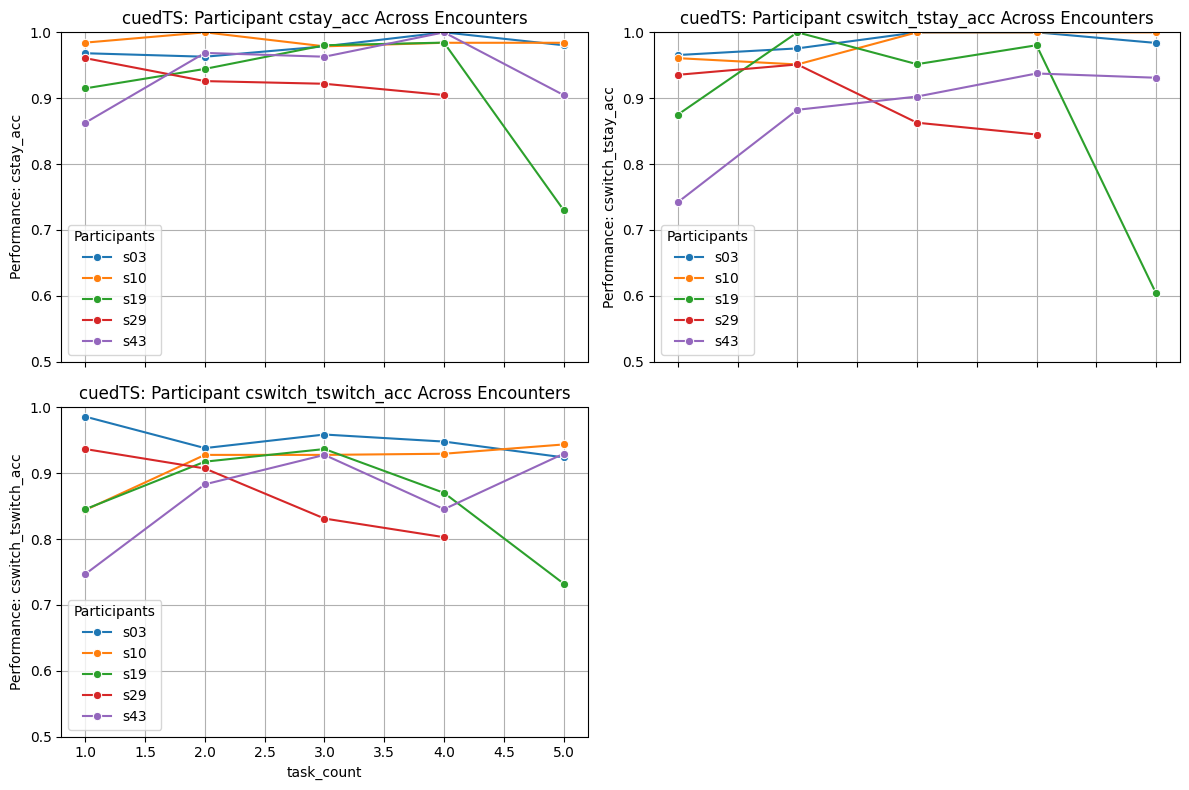

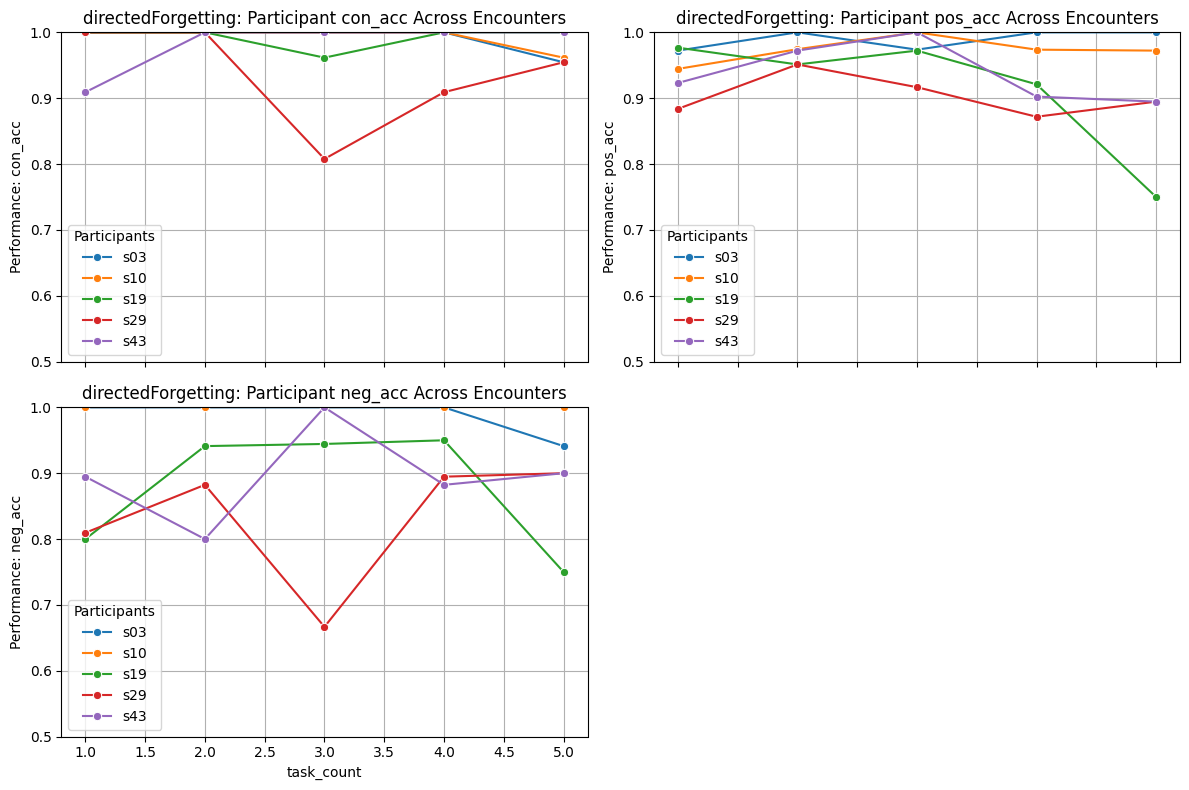

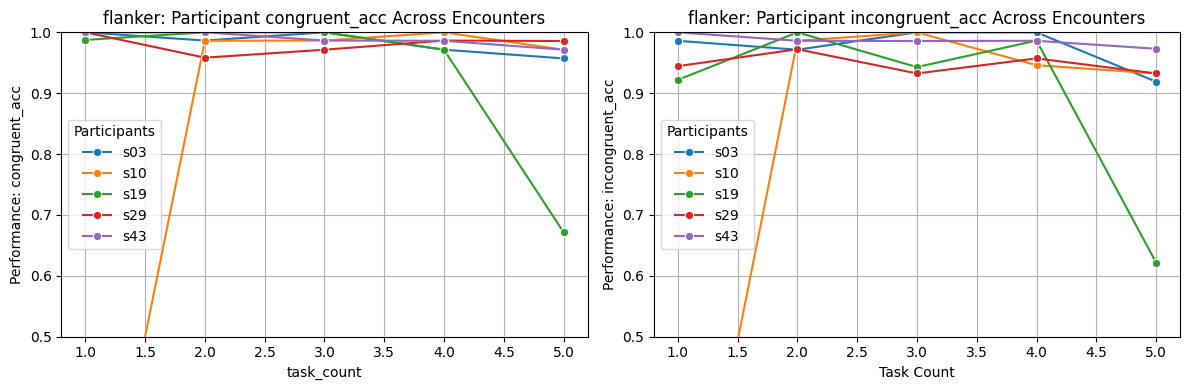

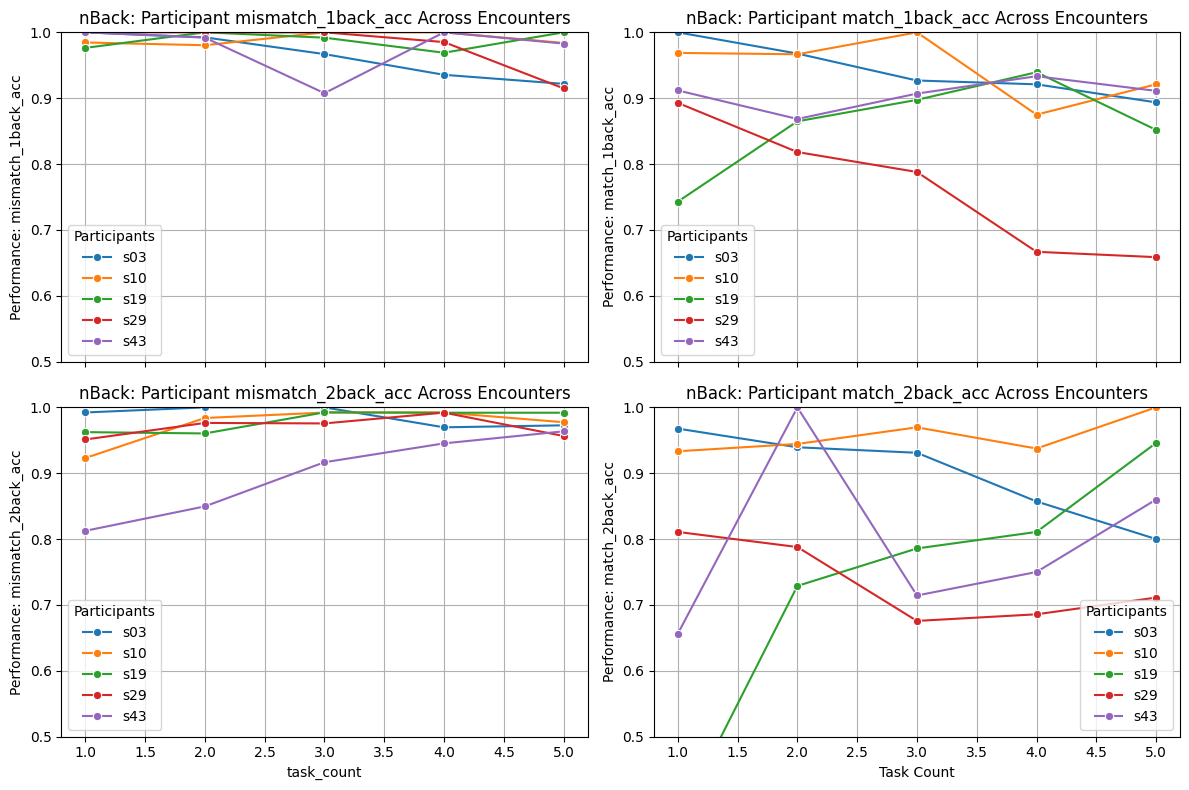

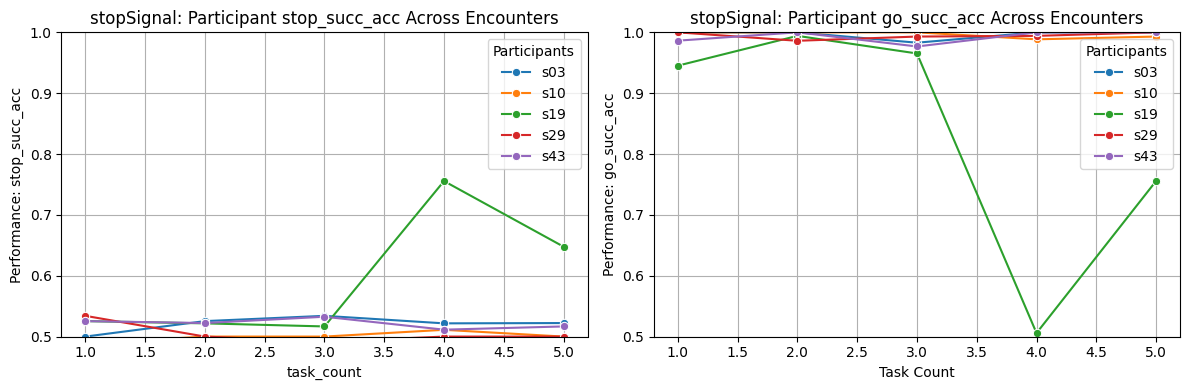

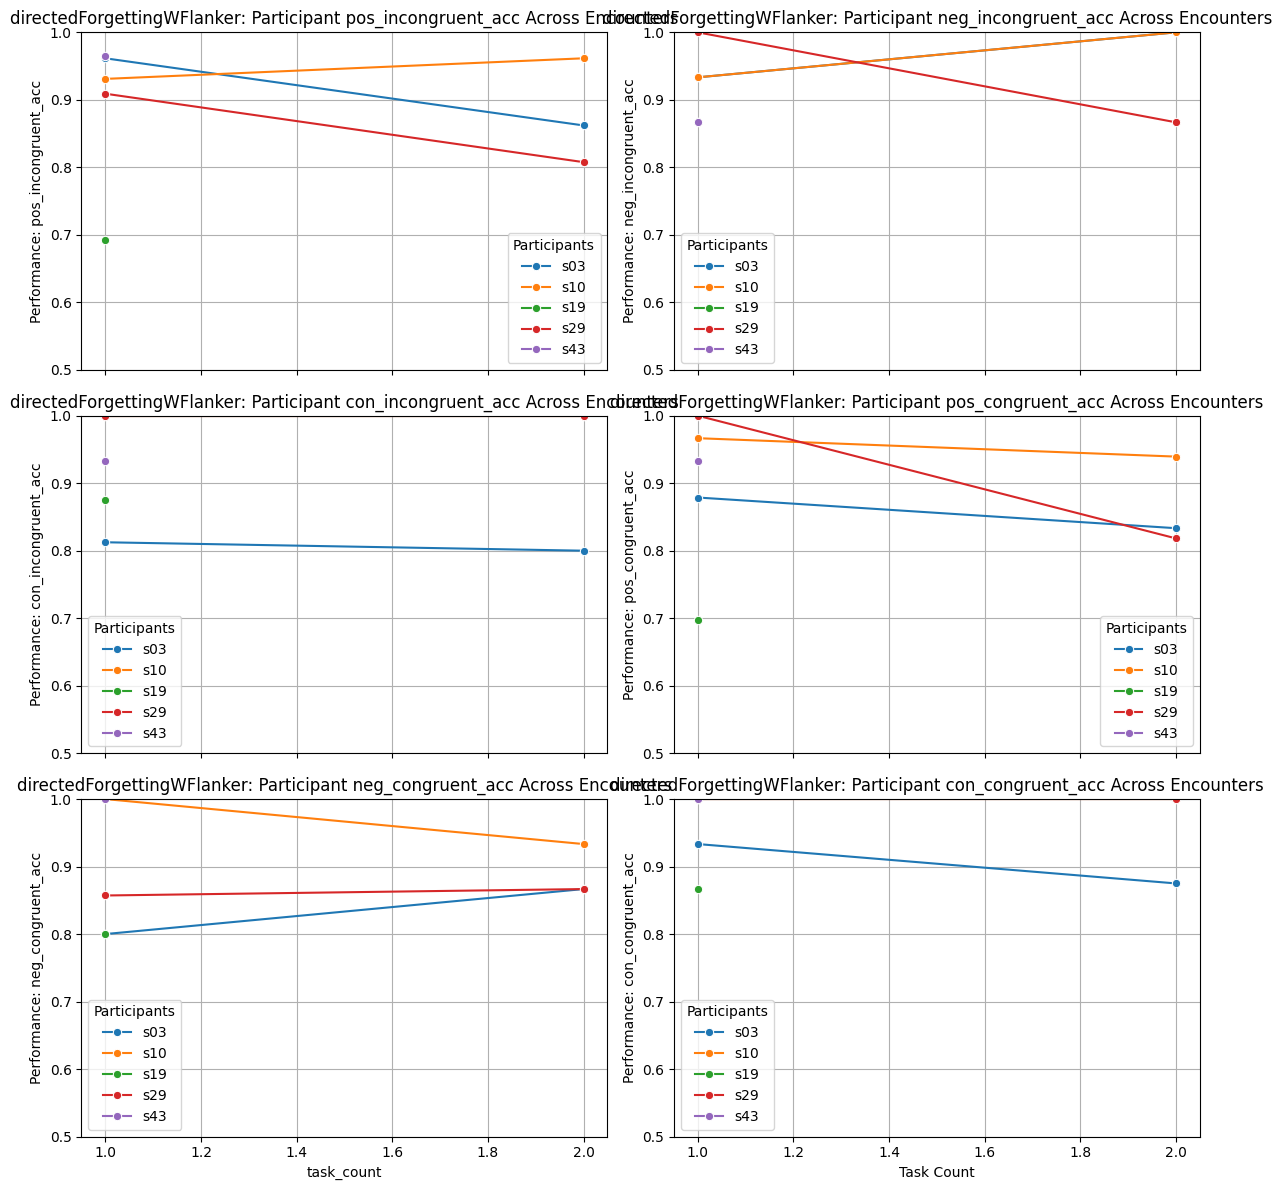

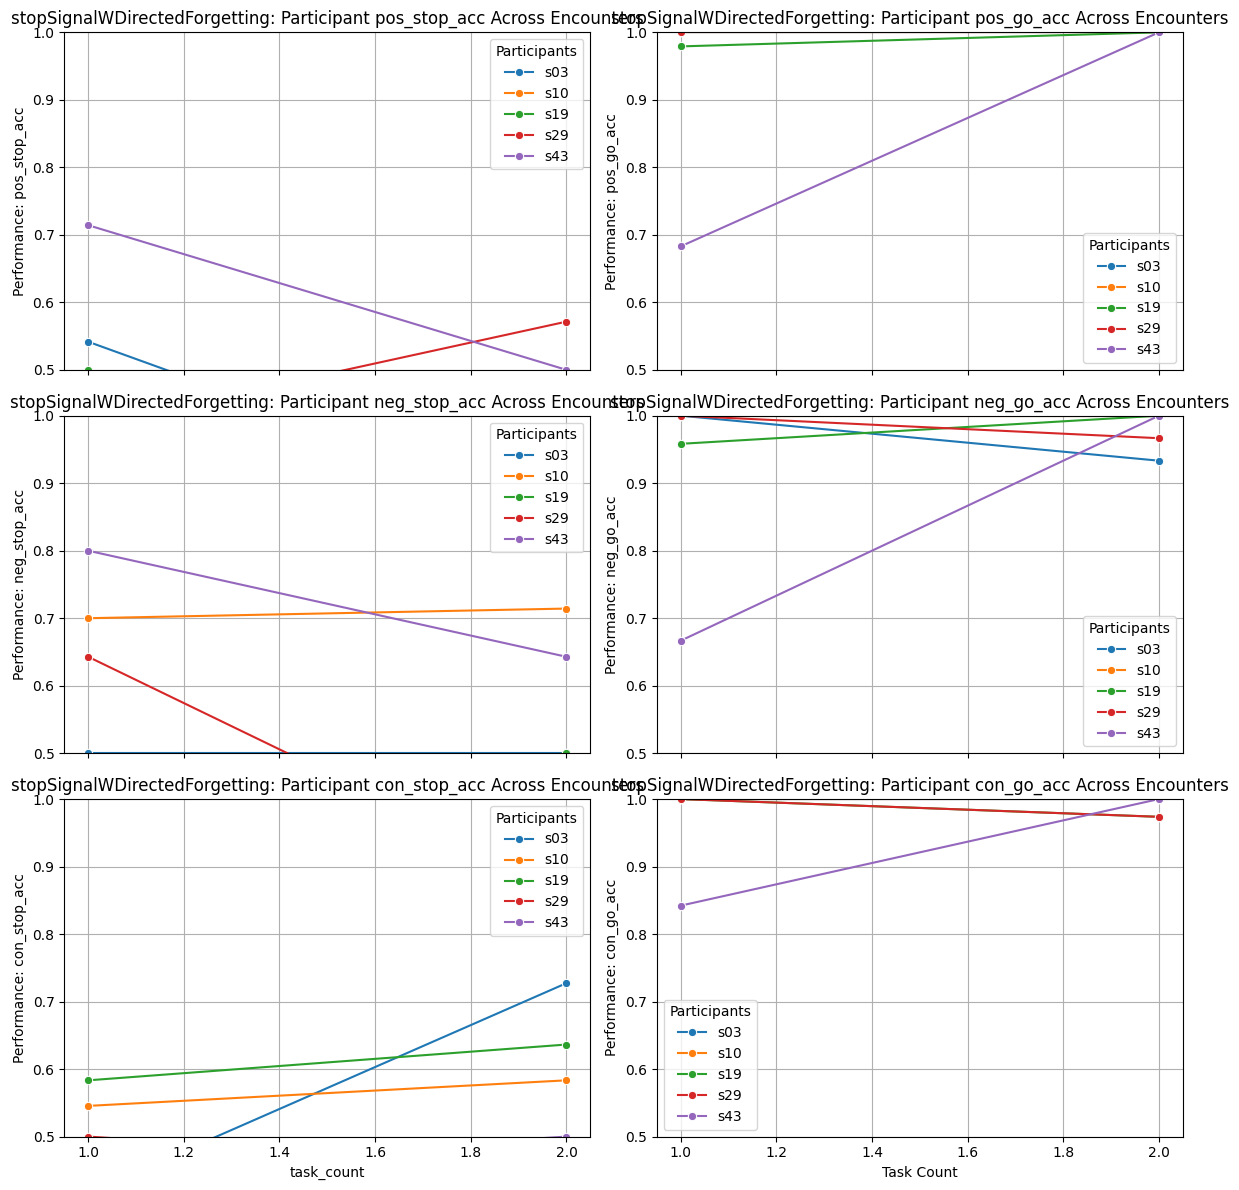

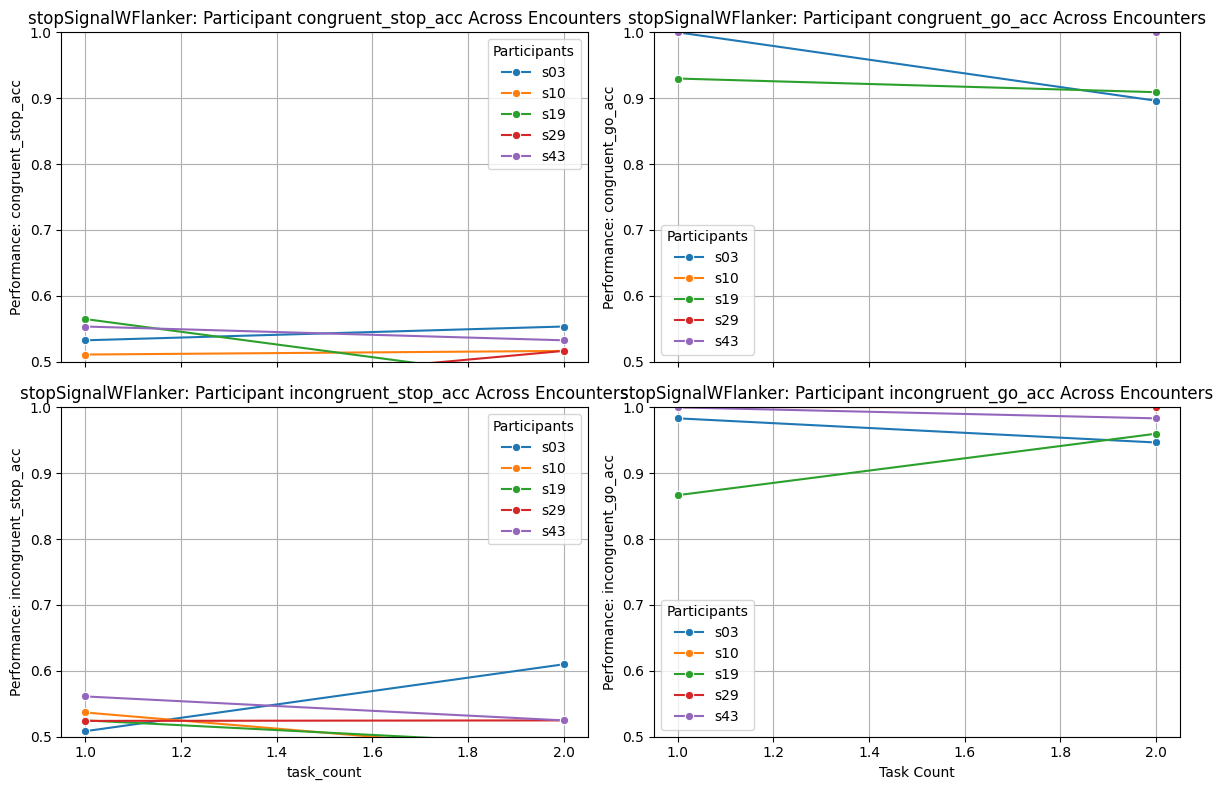

In [15]:
# for task in task_list:
#     curr_df = dfs_task_list[task]
#     for acc_name in task_acc_list[task]:
#         plt.figure(figsize=(12, 6))
#         sns.lineplot(data=curr_df, x='task_count', y=acc_name, hue='subject', marker='o')
        
#         # Aesthetics
#         plt.title(f'{task}: Participant {acc_name} Across Encounters')
#         plt.xlabel('Task Count')
#         plt.ylabel(f'Performance: {acc_name}')
#         plt.legend(title='Participants')
#         plt.grid()
#         plt.show()

for task in task_list:
    curr_df = dfs_task_list[task]
    

    num_acc_names = len(task_acc_list[task])
    num_rows = int(np.ceil(num_acc_names / 2))

    fig, axes = plt.subplots(num_rows, 2, figsize=(12, 4 * num_rows), sharex=True)
    
    axes = axes.flatten()

    for i, acc_name in enumerate(task_acc_list[task]):
        # Plot on subplot
        sns.lineplot(data=curr_df, x='task_count', y=acc_name, hue='subject', marker='o', ax=axes[i])
        
        axes[i].set_title(f'{task}: Participant {acc_name} Across Encounters')
        axes[i].set_ylabel(f'Performance: {acc_name}')
        axes[i].set_ylim(0.5, 1)
        axes[i].legend(title='Participants')
        axes[i].grid()

    # erase unused subplots
    for j in range(num_acc_names, num_rows * 2):
        axes[j].axis('off')

    axes[-1].set_xlabel('Task Count')
    plt.tight_layout()
    
    plt.show()

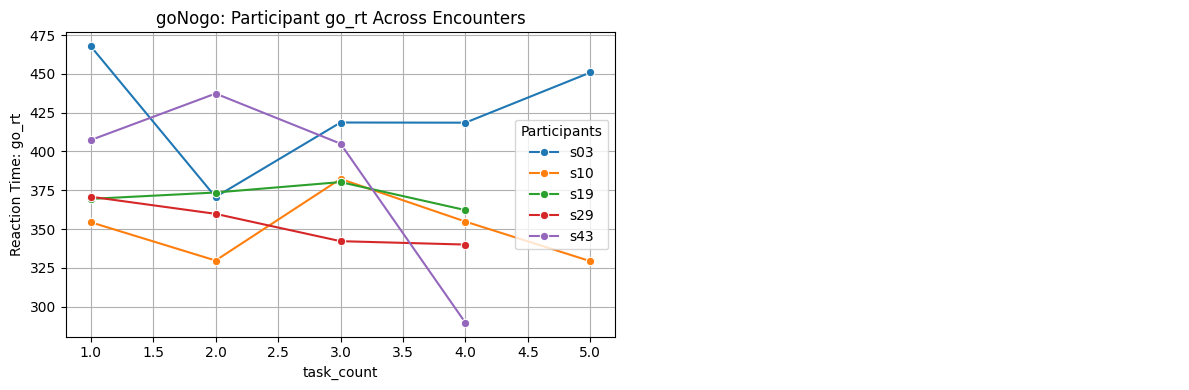

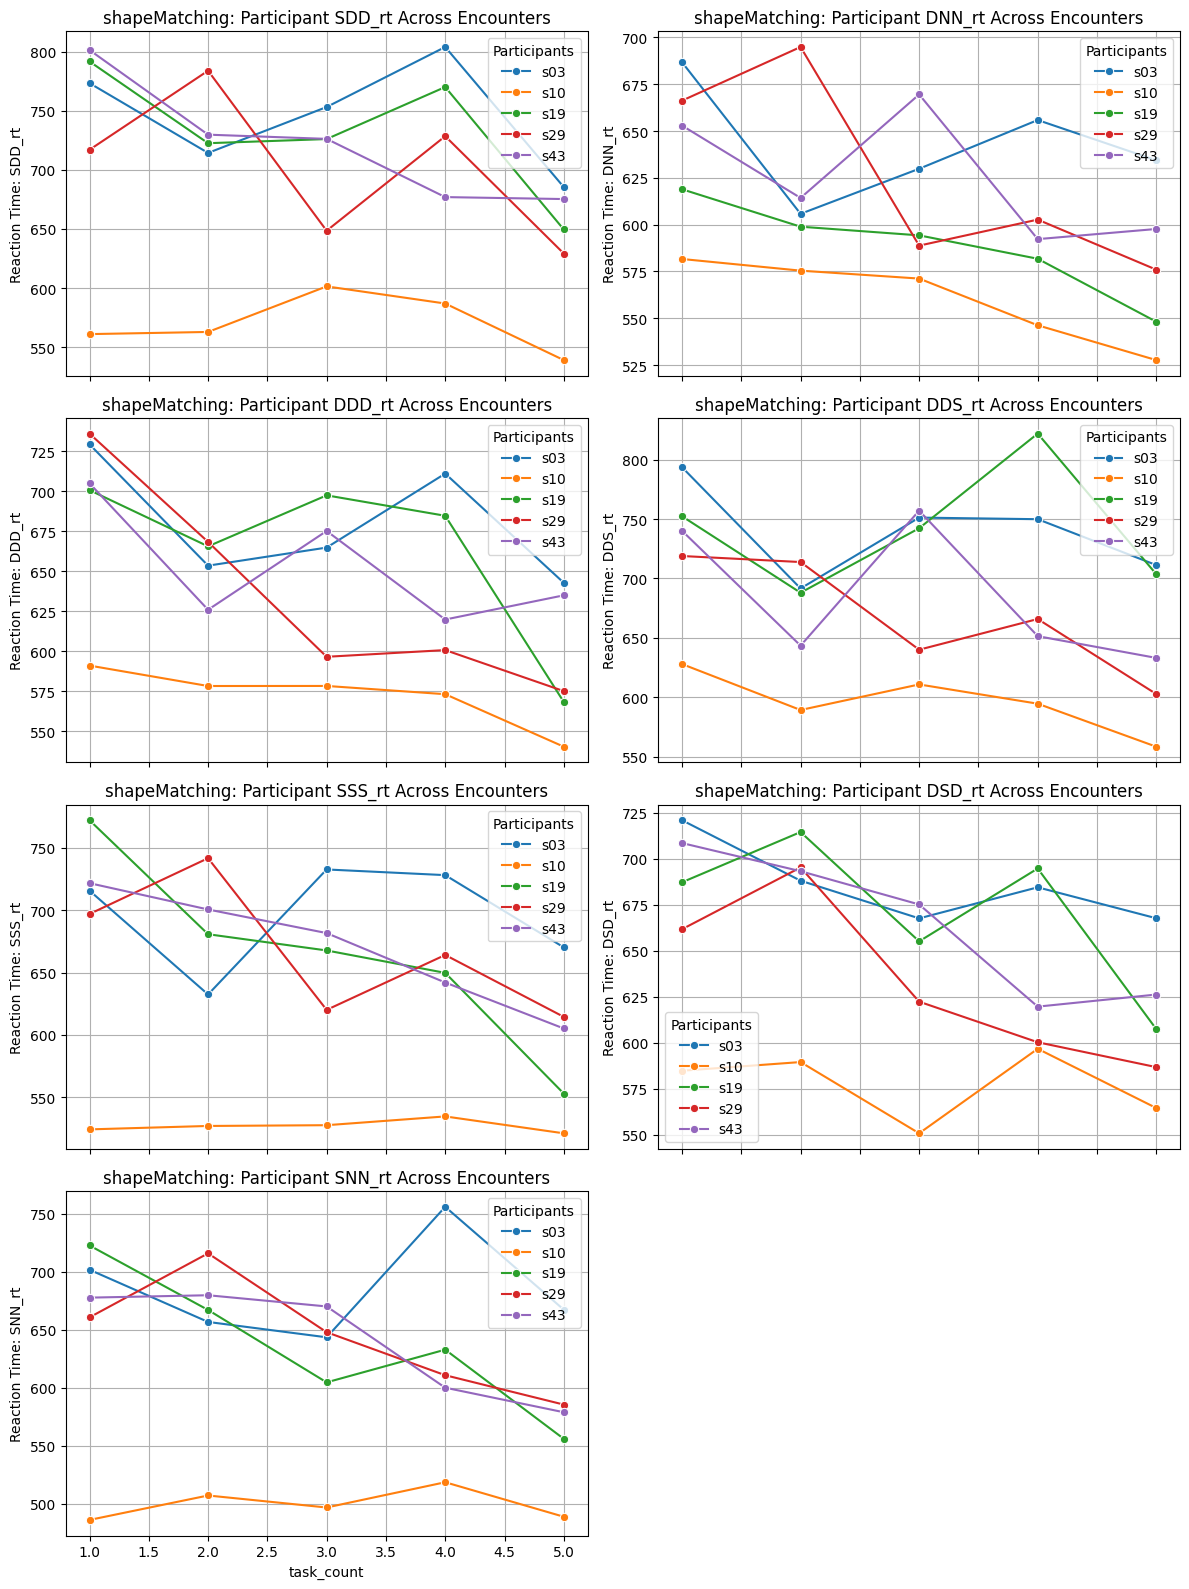

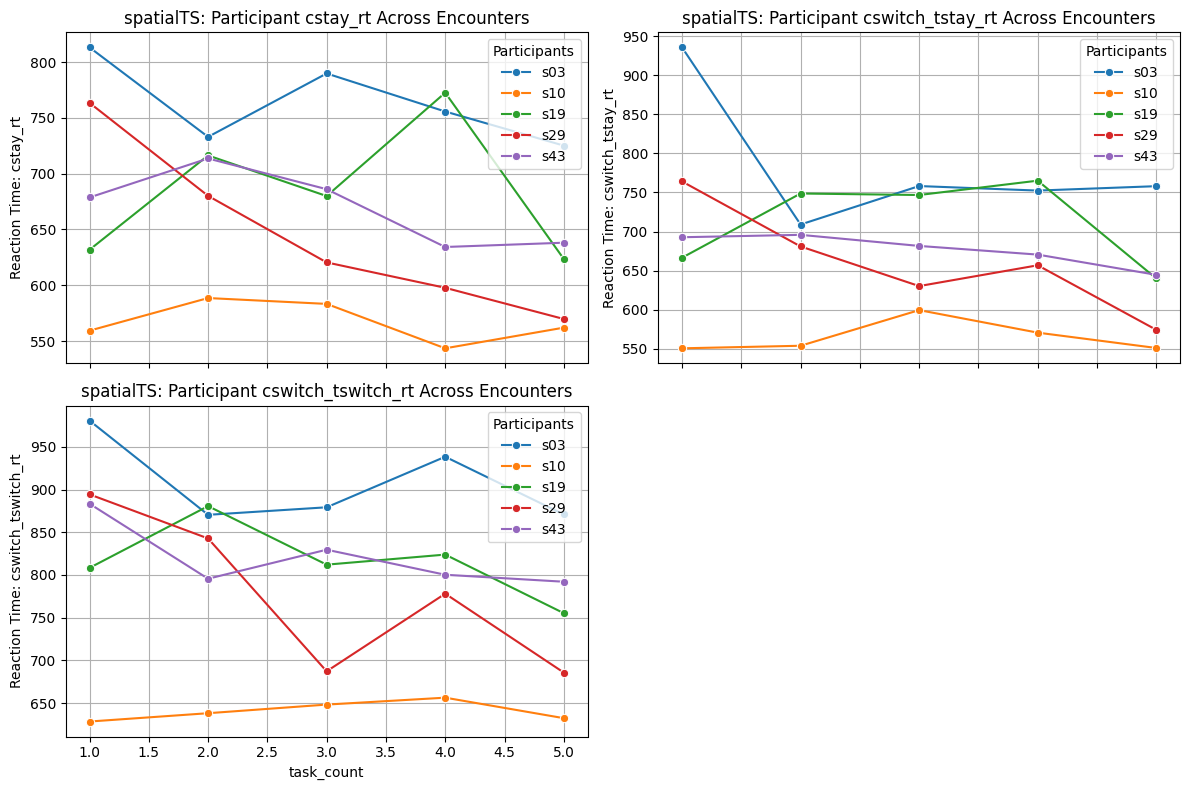

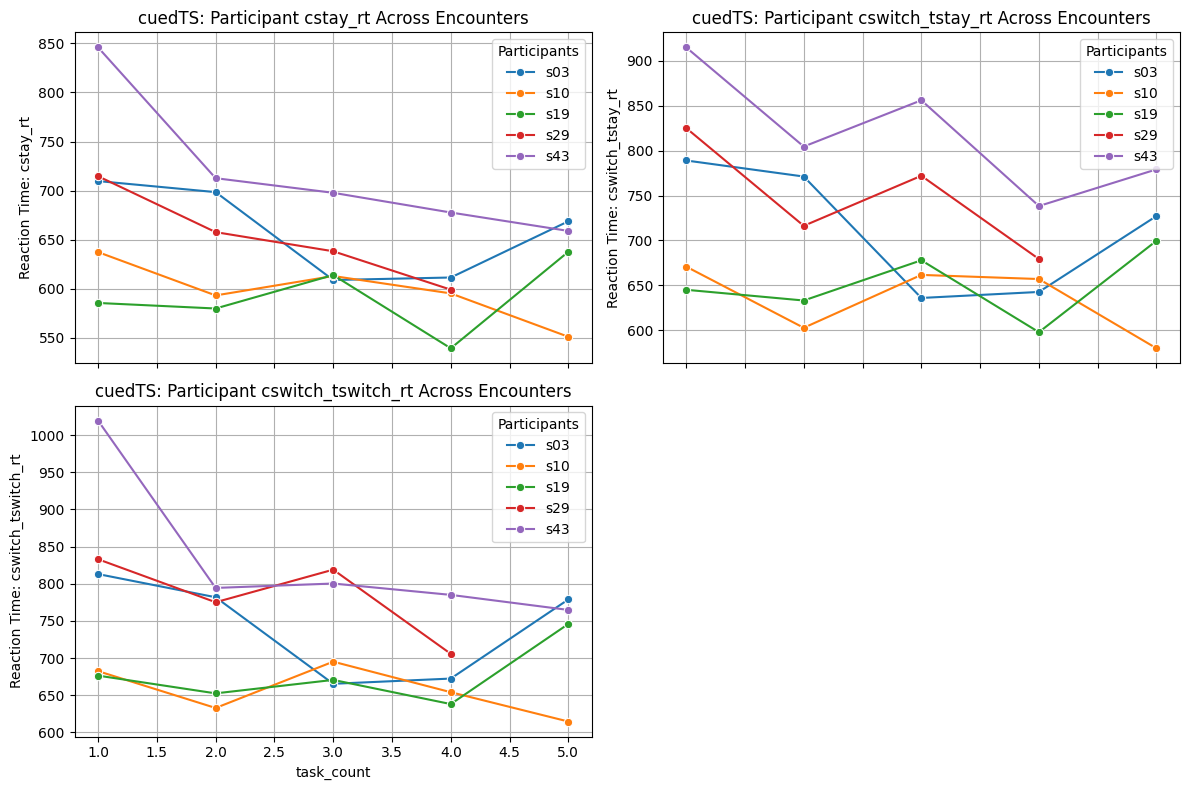

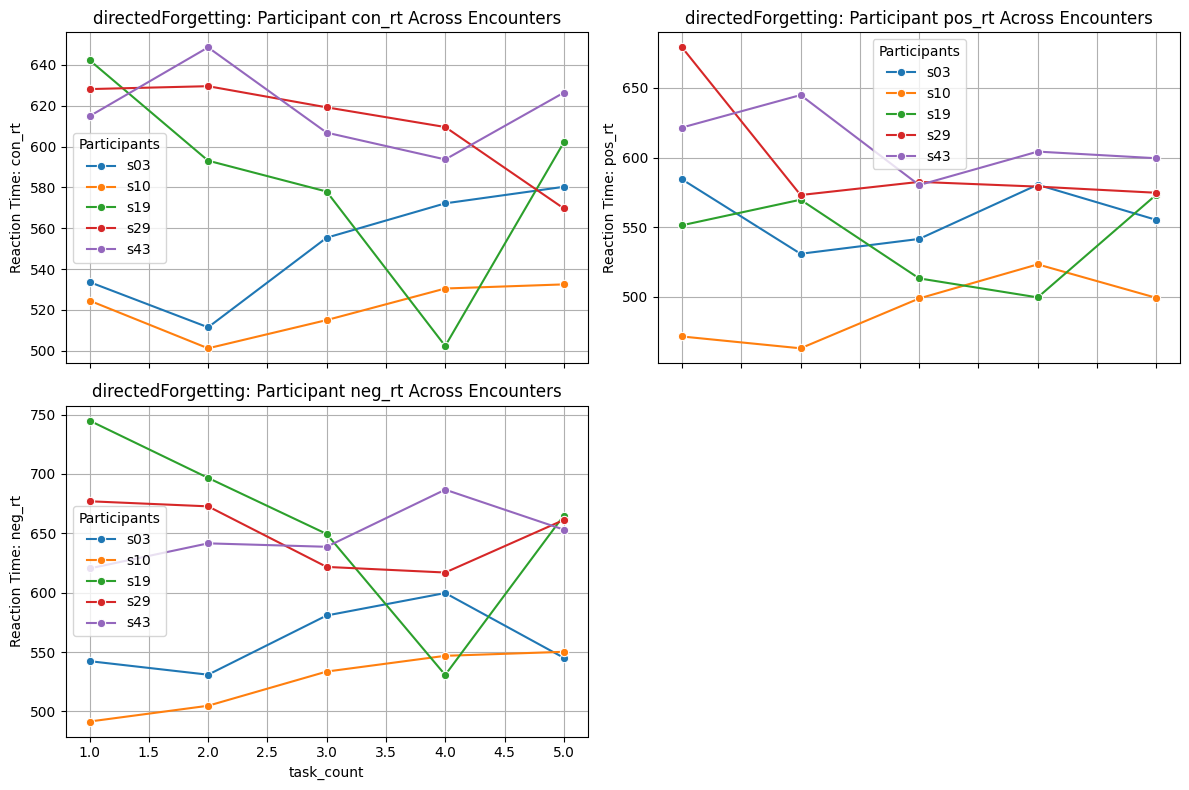

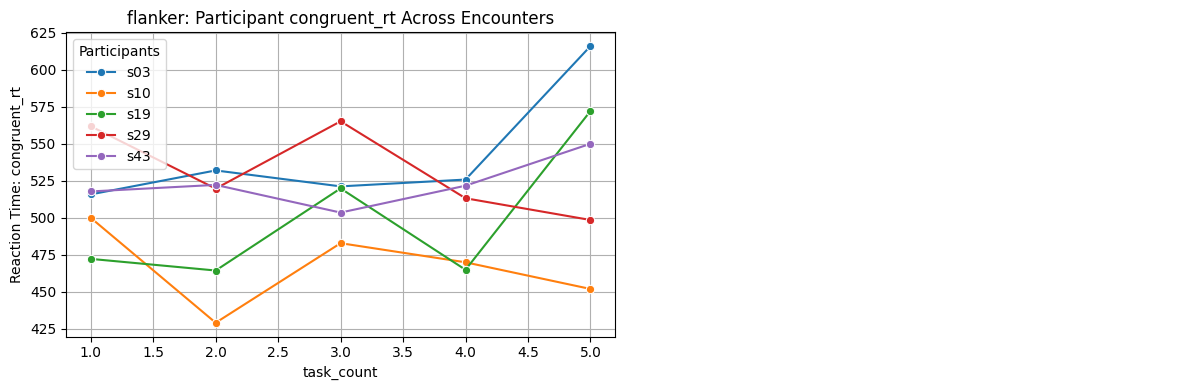

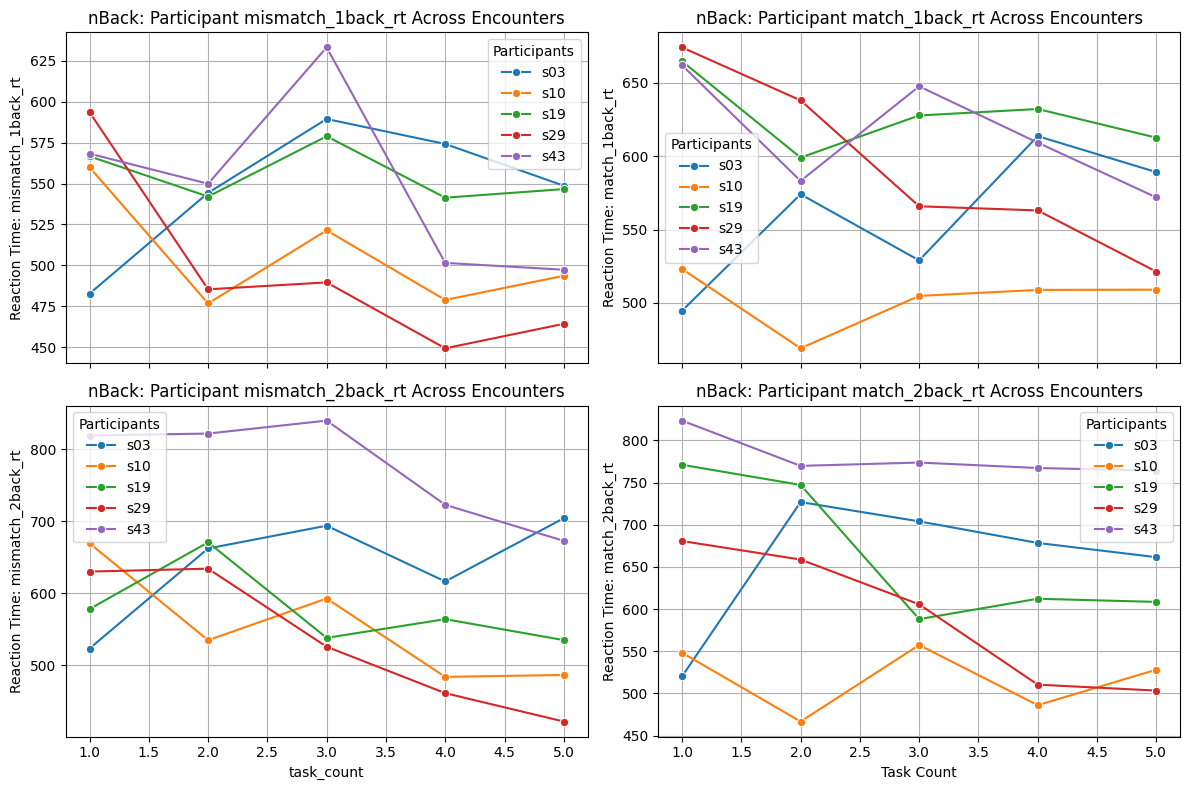

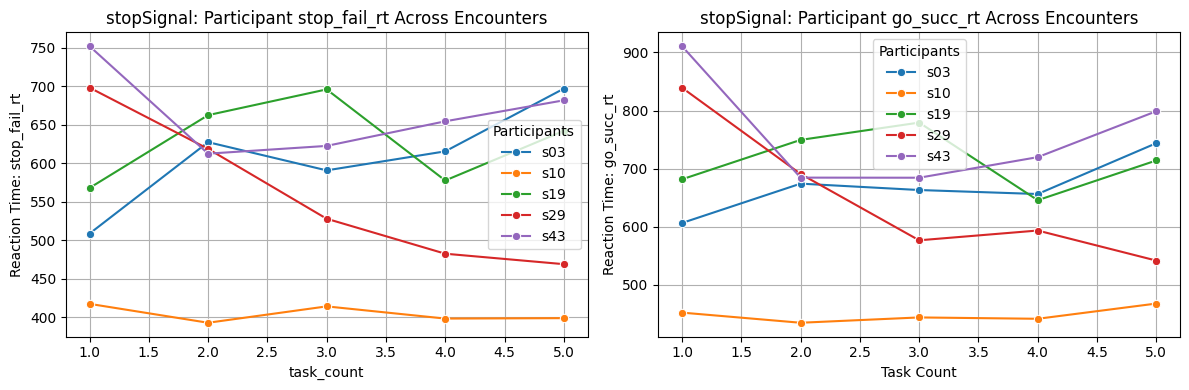

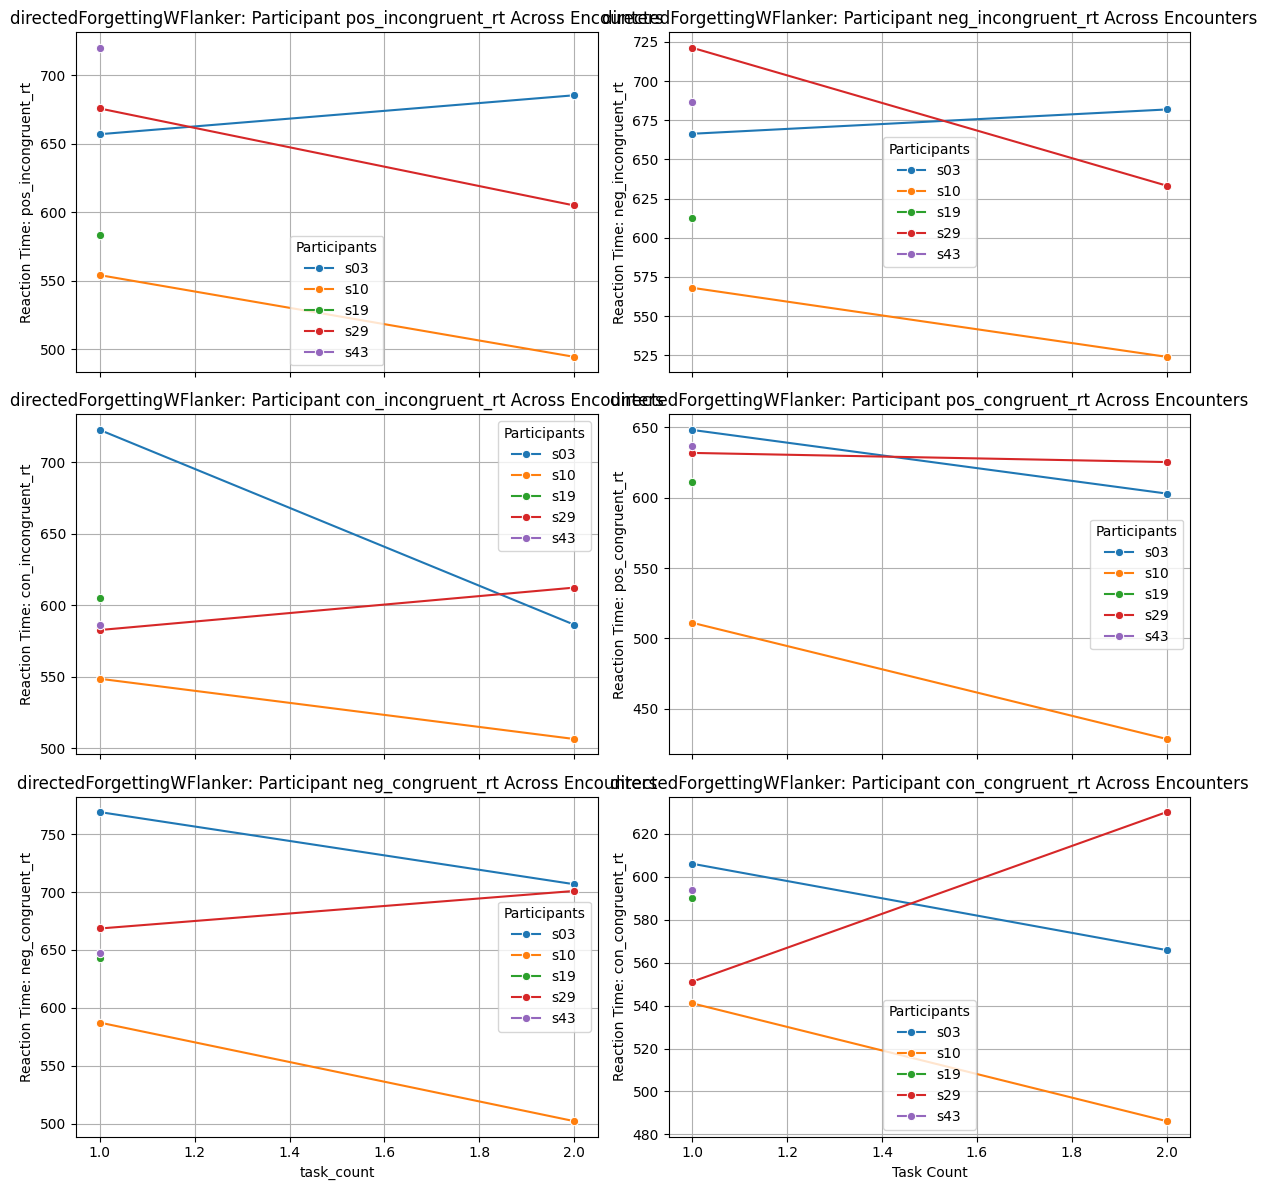

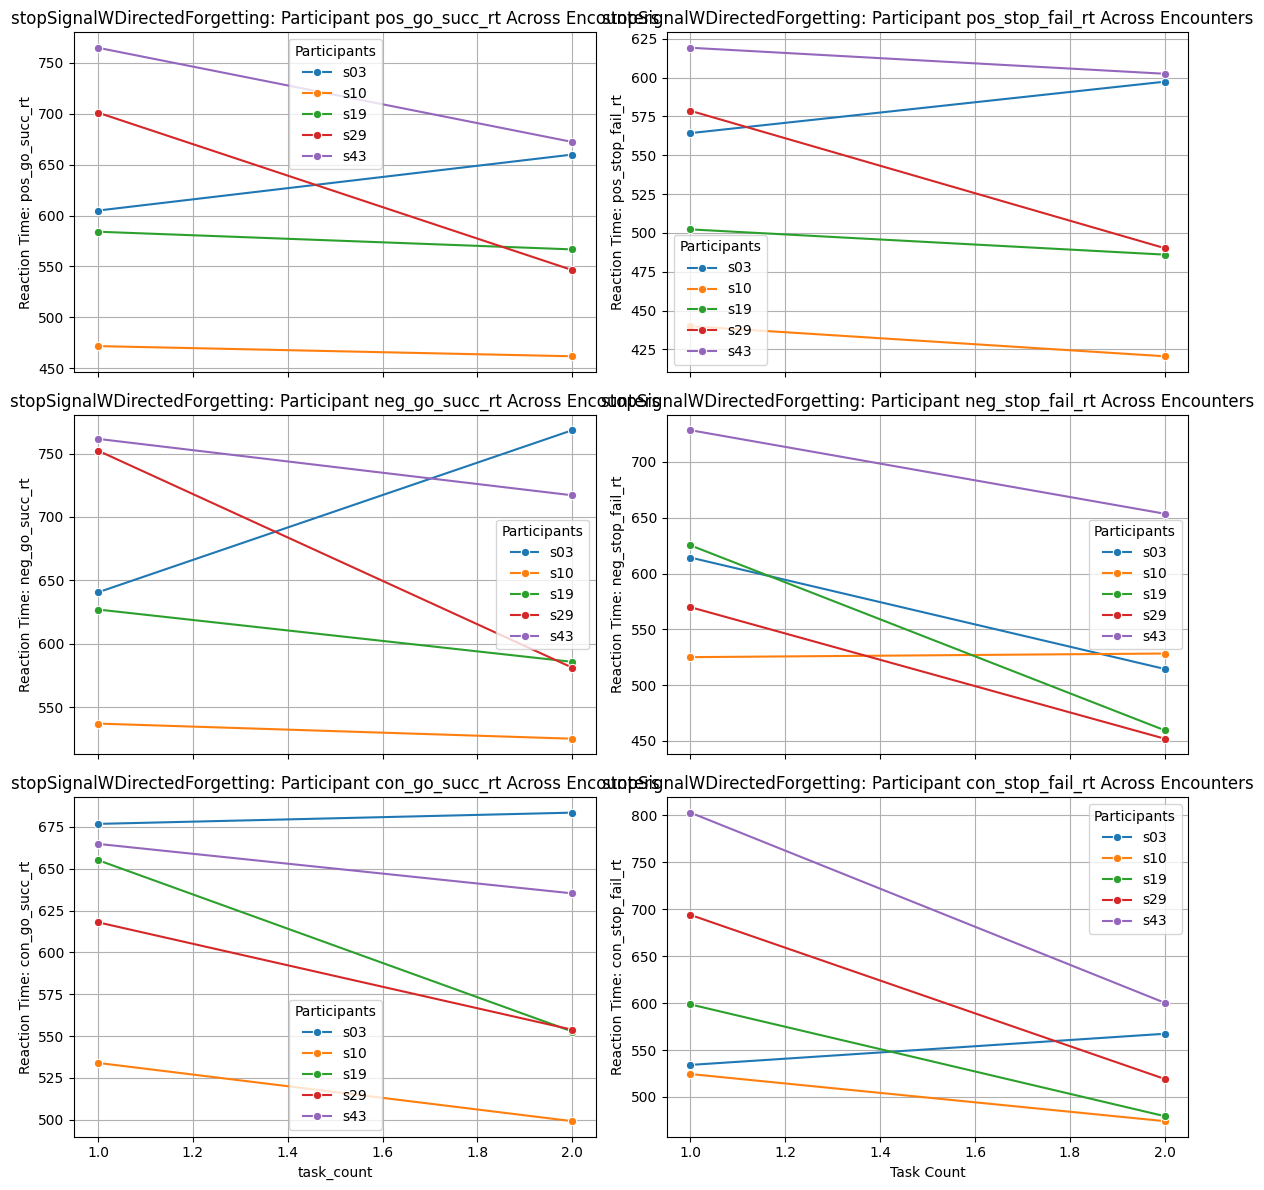

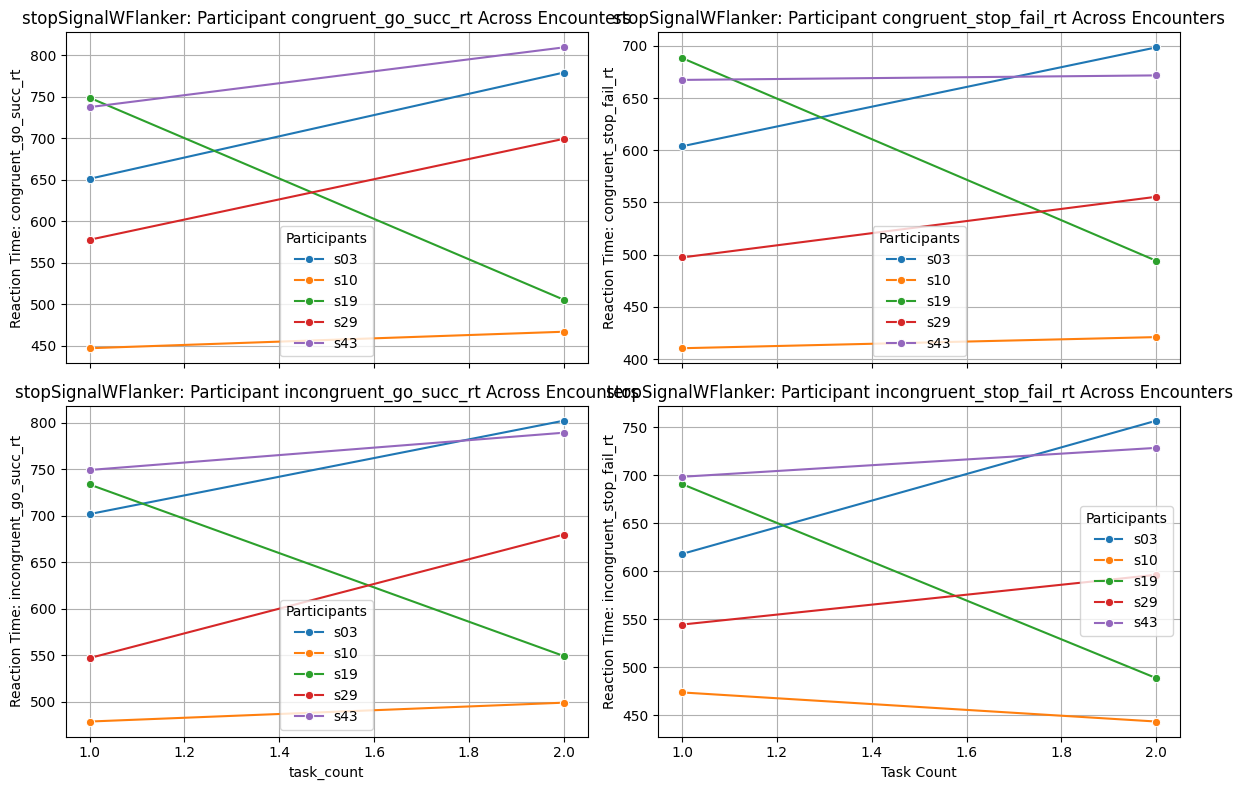

In [13]:
# plot rt change over task count
for task in task_list:
    curr_df = dfs_task_list[task]
    

    num_rt_names = len(task_rt_list[task])
    num_rows = int(np.ceil(num_rt_names / 2))

    fig, axes = plt.subplots(num_rows, 2, figsize=(12, 4 * num_rows), sharex=True)
    
    axes = axes.flatten()

    for i, rt_name in enumerate(task_rt_list[task]):
        # Plot on subplot
        sns.lineplot(data=curr_df, x='task_count', y=rt_name, hue='subject', marker='o', ax=axes[i])
        
        axes[i].set_title(f'{task}: Participant {rt_name} Across Encounters')
        axes[i].set_ylabel(f'Reaction Time: {rt_name}')
        axes[i].legend(title='Participants')
        axes[i].grid()

    # erase unused subplots
    for j in range(num_rt_names, num_rows * 2):
        axes[j].axis('off')

    axes[-1].set_xlabel('Task Count')
    plt.tight_layout()
    
    plt.show()